In [1]:
import pandas as pd
from operator import attrgetter
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from datetime import timedelta
import requests
from scipy.stats import mannwhitneyu
from statsmodels.stats.weightstats import ztest


# Задание 1 - retention

## Функция для рассчета retention

#### Удержание рассчитывается по дням (по условию), когорты взяты по месяцам, чтобы было возможно адекватно оценивать динамику

In [2]:
def calculate_retention(reg_df, auth_df):
    """
    Вычисляет retention-матрицу пользователей на основе данных о регистрации и авторизации

    Параметры:
    reg_df (pd.DataFrame) :  ['uid', 'reg_ts'] , 'reg_ts'  —  время регистрации
    auth_df (pd.DataFrame):  ['uid', 'auth_ts'], 'auth_ts' —  время авторизации

    Возвращает:
    pd.DataFrame: retention-матрица, где строки — месячные когорты (по дате регистрации),
                  столбцы — количество дней с момента регистрации,
                  значения — доля пользователей, вернувшихся в соответствующий день
    """
    reg_df = reg_df.copy()
    auth_df = auth_df.copy()
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s')
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')

    reg_df = reg_df.rename(columns={'reg_ts': 'registration_date'})
    auth_df = auth_df.rename(columns={'auth_ts': 'auth_date'})
    merged_df = pd.merge(auth_df, reg_df, on='uid')

    merged_df['registration_date'] = merged_df['registration_date'].dt.floor('D')
    merged_df['auth_date'] = merged_df['auth_date'].dt.floor('D')
    merged_df['cohort'] = merged_df['registration_date'].dt.to_period('M')
    merged_df['days_since_reg'] = (merged_df['auth_date'] - merged_df['registration_date']).dt.days
    merged_df = merged_df[merged_df['days_since_reg'] >= 0]

    retention_counts = (
        merged_df.groupby(['cohort', 'days_since_reg'])['uid']
        .nunique()
        .reset_index()
    )

    retention_matrix = retention_counts.pivot_table(
        index='cohort',
        columns='days_since_reg',
        values='uid'
    )

    cohort_sizes = retention_matrix[0]
    retention_matrix = retention_matrix.divide(cohort_sizes, axis=0)

    return retention_matrix

In [3]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

### EDA

In [7]:
# Размеры датафреймов
print(f"Размер reg_df: {reg_data.shape}")
print(f"Размер auth_df: {auth_data.shape}")

Размер reg_df: (1000000, 2)
Размер auth_df: (9601013, 2)


In [10]:
# Общая информация
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [11]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [12]:
#Пропуски - нет
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [13]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [15]:
#Дубликаты - нет
reg_data.duplicated().sum()

0

In [16]:
auth_data.duplicated().sum()

0

In [19]:
# Кол-во пользователей совпадает
print(f"Уникальных пользователей в reg_data: {reg_data['uid'].nunique()}")
print(f"Уникальных пользователей в auth_data: {auth_data['uid'].nunique()}")

Уникальных пользователей в reg_data: 1000000
Уникальных пользователей в auth_data: 1000000


In [23]:
#Ошибок вида: пользователь зашел, но не был зарегестрирован нет
unauthorized = set(reg_data['uid']) - set(auth_data['uid'])
print(f"Пользователей, авторизованных без регистрации: {len(unauthorized)}")

Пользователей, авторизованных без регистрации: 0


In [24]:
#Зарегестрированных, но не разу не вошедших нет
unreg = set(auth_data['uid']) - set(reg_data['uid'])
print(f"Пользователей, которые зарегались, но не входили: {len(unreg)}")

Пользователей, которые зарегались, но не входили: 0


In [26]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

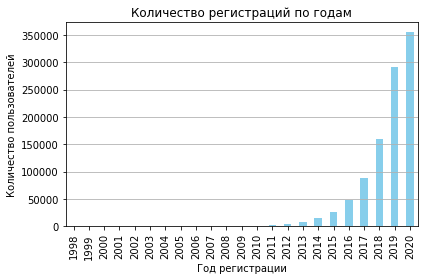

In [30]:
# Распределение по годам 
reg_by_year = reg_data['reg_ts'].dt.year.value_counts().sort_index()
reg_by_year.plot(kind='bar', title='Количество регистраций по годам', figsize=(6, 4), color='skyblue')
plt.xlabel('Год регистрации')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

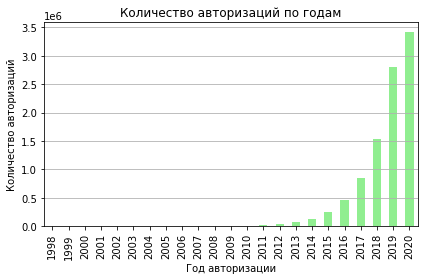

In [31]:
# Распределение по годам
auth_by_year = auth_data['auth_ts'].dt.year.value_counts().sort_index()
auth_by_year.plot(kind='bar', title='Количество авторизаций по годам', figsize=(6, 4), color='lightgreen')
plt.xlabel('Год авторизации')
plt.ylabel('Количество авторизаций')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
auth_df['auth_date'] = auth_data['auth_ts'].dt.date
auth_counts = auth_data['auth_date'].value_counts().sort_index()

auth_counts.plot(kind='bar', title='Распределение авторизаций по датам', figsize=(8, 4))

In [25]:
#Беру сэмпл за поледний год
cutoff_date = reg_data['reg_ts'].max() - timedelta(days=365)

recent_reg = reg_data[reg_data['reg_ts'] >= cutoff_date]
recent_uids = recent_reg['uid'].unique()


reg_recent = reg_data[reg_data['uid'].isin(recent_uids)]
auth_recent = auth_data[auth_data['uid'].isin(recent_uids)]

In [26]:
retention_matrix = calculate_retention(reg_recent, auth_recent)

In [28]:
retention_matrix

days_since_reg,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
cohort,,,,,,,,,,,,,,,,,,,,,
2019-09,1.0,0.020620,0.040374,0.045573,0.053717,0.063594,0.066020,0.061688,0.048518,0.045919,...,0.009704,0.011610,0.012996,0.01005,0.010224,0.006411,0.005025,0.004852,0.00156,0.000173
2019-10,1.0,0.020519,0.042279,0.043313,0.052348,0.060039,0.070177,0.056487,0.048348,0.052245,...,0.000862,0.000448,0.000241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11,1.0,0.020268,0.043484,0.045891,0.051008,0.059820,0.068056,0.059956,0.046840,0.048941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12,1.0,0.019715,0.040272,0.047447,0.054653,0.059737,0.069470,0.059706,0.047478,0.052500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01,1.0,0.020425,0.040880,0.047580,0.052649,0.056621,0.070080,0.056769,0.047995,0.050129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02,1.0,0.020059,0.041687,0.044492,0.051309,0.060569,0.069438,0.055773,0.046664,0.049771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03,1.0,0.019607,0.040746,0.047407,0.052134,0.059655,0.068840,0.058338,0.048427,0.051382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04,1.0,0.021328,0.042657,0.045719,0.053875,0.060870,0.070056,0.058943,0.047329,0.052212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05,1.0,0.018975,0.041012,0.046333,0.053111,0.060716,0.067592,0.058529,0.048155,0.050220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Задание 2 - анализ А/B теста

In [33]:
api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
params = {'public_key': "https://disk.yandex.ru/d/SOkIsD5A8xlI7Q"}
response = requests.get(api_url, params=params)
download_url = response.json()['href']

In [34]:
results = pd.read_csv(download_url, sep=';')

In [35]:
results.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


### Проверим данные теста 

In [6]:
#Размер выборок примерно одинаковый - ОК
results['testgroup'].value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [7]:
#Пользователи в группах не повторяются - ОК
assert results['user_id'].is_unique, "Есть дубликаты"

In [8]:
#пропусков нет - ОК
results.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

### Разделим группы и рассчитаем метрики (ARPU, ARPPU, CR в платящего)

In [39]:
group_a = results.query('testgroup == "a"')

In [40]:
group_b = results.query('testgroup == "b"')

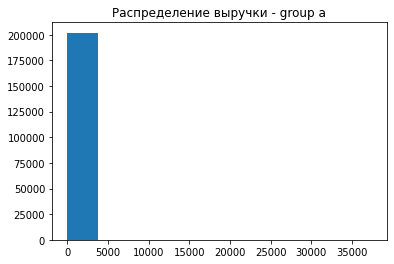

In [41]:
plt.hist(group_a['revenue'])
plt.title("Распределение выручки - group a")
plt.show()

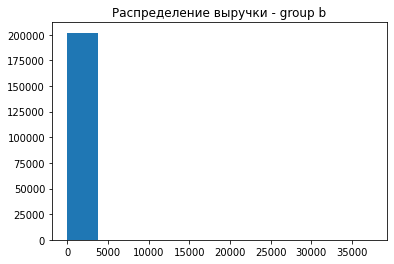

In [42]:
plt.hist(group_a['revenue'])
plt.title("Распределение выручки - group b")
plt.show()

Оценить распределение по всем юзерам сложно, т.к. в основном юзеры ничего не платят

In [43]:
gr_a_pay = group_a.query('revenue > 0')

In [44]:
gr_b_pay = group_b.query('revenue > 0')

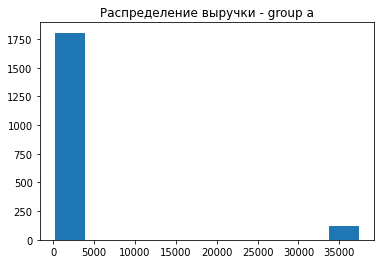

In [45]:
plt.hist(gr_a_pay['revenue'])
plt.title("Распределение выручки - group a")
plt.show()

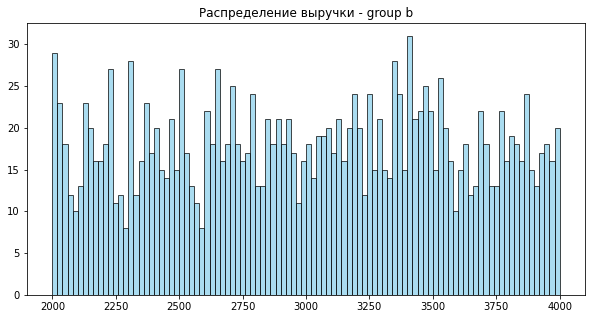

In [46]:
plt.figure(figsize=(10, 5))
plt.hist(gr_b_pay['revenue'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Распределение выручки - group b")
plt.show()

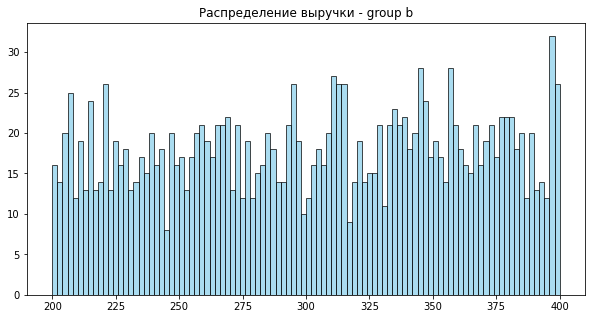

In [47]:
plt.figure(figsize=(10, 5))
plt.hist(gr_a_pay.query('revenue < 5000')['revenue'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Распределение выручки - group b")
plt.show()

Если посмотреть распределение уже по платящим, то видно, что в тестовой группе оно распределено равномерно, в то время как в контроле есть пользователи которые платят мало и очень много. Если убрать значения выбросов в контроле, то в основном юзеры платят меньше, чем в тестовой группе.

По результатам предварительного анализа возникает обоснованное подозрение, что экспериментальный дизайн мог быть нарушен:

При схожем размере групп, в них наблюдается разная структура платящего сегмента Это может указывать на некорректное сплитование — например, если пользователи были разбиты неслучайным образом или по признакам, коррелирующим с вероятностью оплаты.

### Стат. анализ

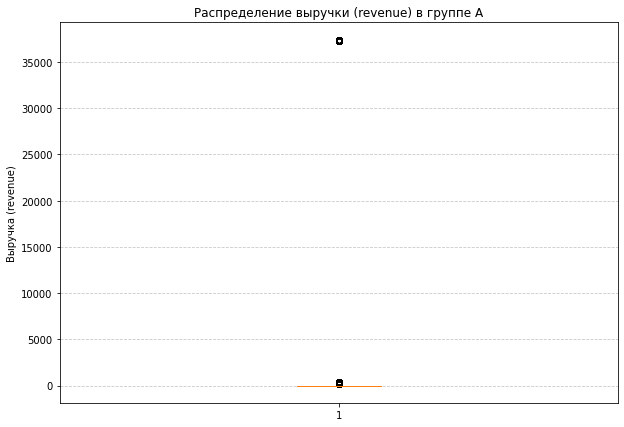

In [57]:
fig = plt.figure(figsize=(10, 7))
plt.boxplot(group_a['revenue'], patch_artist=True)
plt.title('Распределение выручки (revenue) в группе A')
plt.ylabel('Выручка (revenue)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

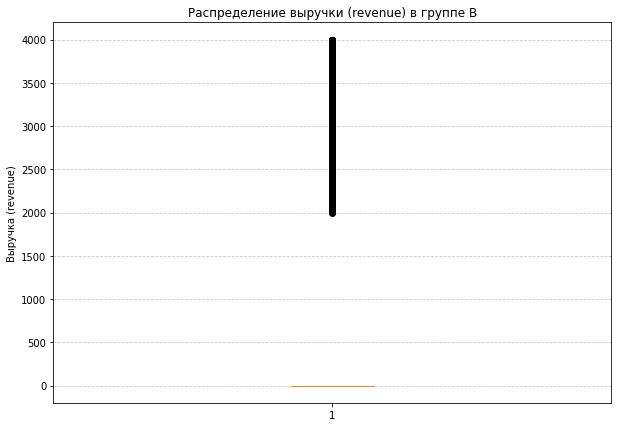

In [58]:
fig = plt.figure(figsize=(10, 7))
plt.boxplot(group_b['revenue'], patch_artist=True)
plt.title('Распределение выручки (revenue) в группе B')
plt.ylabel('Выручка (revenue)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

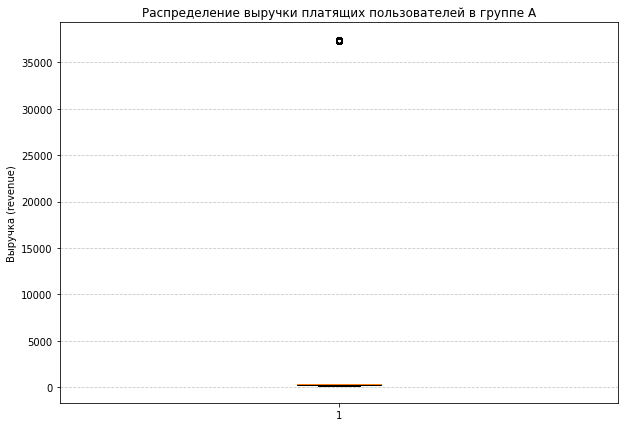

In [59]:
fig = plt.figure(figsize=(10, 7))
plt.boxplot(group_a.query('revenue > 0')['revenue'], patch_artist=True)
plt.title('Распределение выручки платящих пользователей в группе A')
plt.ylabel('Выручка (revenue)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

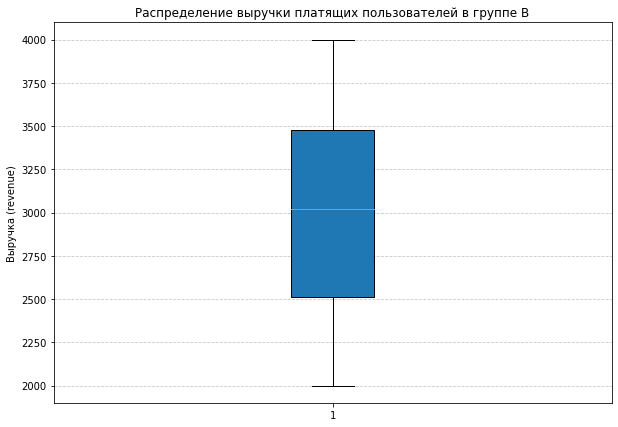

In [60]:
fig = plt.figure(figsize=(10, 7))
plt.boxplot(group_b.query('revenue > 0')['revenue'], patch_artist=True)
plt.title('Распределение выручки платящих пользователей в группе B')
plt.ylabel('Выручка (revenue)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### ARPU, ARPPU

Данные по revenue — сильно скошены, много нулей, распределение не нормальное. Это делает классические t-тесты небезопасными.

Выбираем Bootstrap — он не требует нормальности распределения и хорошо подходит для оценки доверительных интервалов

#### Для ARPU:

H0: Средний доход на пользователя (ARPU) в группах A и B не отличается.

H1: Средний доход на пользователя (ARPU) в группах A и B различается.


#### Для ARPPU:
Считаем только платящих пользователей (revenue > 0).

H0: Средний доход на платящего пользователя (ARPPU) в группах A и B равен
    
H1: Средний доход на платящего пользователя (ARPPU) в группах A и B различается

In [48]:
def bootstrap_diff_means(data_a, data_b, n_boot=10000):
    diffs = []
    combined = np.concatenate([data_a, data_b])
    n_a, n_b = len(data_a), len(data_b)
    for _ in range(n_boot):
        sample_a = np.random.choice(data_a, n_a, replace=True)
        sample_b = np.random.choice(data_b, n_b, replace=True)
        diffs.append(sample_b.mean() - sample_a.mean())
    diffs = np.array(diffs)
    p_value = 2 * min((diffs <= 0).mean(), (diffs >= 0).mean())
    return diffs, p_value

In [49]:
# Данные для ARPU (все пользователи)
data_a = group_a['revenue'].values
data_b = group_b['revenue'].values

diffs_arpu, p_arpu = bootstrap_diff_means(data_a, data_b)

print(f"Bootstrap p-value для ARPU: {p_arpu:.4f}")

Bootstrap p-value для ARPU: 0.5444


In [50]:
# Данные для ARPPU (только платящие)
data_a_pay = group_a.loc[group_a['revenue'] > 0, 'revenue'].values
data_b_pay = group_b.loc[group_b['revenue'] > 0, 'revenue'].values

diffs_arppu, p_arppu = bootstrap_diff_means(data_a_pay, data_b_pay)

print(f"Bootstrap p-value для ARPPU: {p_arppu:.4f}")

Bootstrap p-value для ARPPU: 0.1098


### CR

Конверсия — это бинарная метрика: платящий/неплатящий

Мы хотим проверить, есть ли статистически значимое различие в долях платящих между группами

Для сравнения двух долей в независимых выборках подходит z-тест для разницы пропорций

H0: Конверсия (доля платящих) в группах A и B равна

H1: Конверсия в группах A и B различается

In [52]:
success_a = (group_a['revenue'] > 0).sum()
success_b = (group_b['revenue'] > 0).sum()
n_a = len(group_a)
n_b = len(group_b)

count = np.array([success_a, success_b])
nobs = np.array([n_a, n_b])

stat, pval = ztest(count, nobs)

print(f"Z-тест для конверсии: stat={stat:.4f}, p-value={pval:.4f}")

Z-тест для конверсии: stat=-694.7294, p-value=0.0000


#### По ARPU:
Bootstrap-анализ показал отсутствие статистически значимых различий между тестовой и контрольной группами (p-value ≈ 0.54). Это значит, что в среднем доход на пользователя в обеих группах схож.

#### По ARPPU:
Результаты bootstrap-теста дали p-value ≈ 0.11, что также не позволяет утверждать о наличии статистически значимой разницы. Следовательно, среди платящих пользователей средний доход в группах не различается существенно.

#### По конверсии:
В Z-тест p-value = 0, что свидетельствует о статистически значимом отличии конверсии между группами. При этом тестовая группа имеет меньшую долю платящих по сравнению с контролем.

#### Интерпретация и рекомендации

Важные нюансы:
1 - Распределение выручки в группе A сильно неравномерное, большинство платящих тратят меньше, чем в группе B.
2 - Медиана платежей в группе B выше, монетизация в группе B структурно лучше и не объясняется единичными крупными платежами.
3 - Группа B приносит более стабильных и массовых платящих пользователей с относительно предсказуемыми платежами (обычно в диапазоне 2.5–3.5 тыс. рублей).
4 - Несмотря на то, что ARPU и ARPPU выше в тестовой группе, снижение конверсии платящих вызывает вопросы о стабильности и достоверности результатов.

Рекомендуется провести дополнительные тесты на балансировку групп.При подтверждении несбалансированности — необходимо пересформировать группы и повторить эксперимент для получения корректных и надёжных результатов.

# Задание 3 - метрики приложения

## Метрики стандарных событий Plants & Gardens

#### Описание:
Каждый месяц проводятся тематические события, ограниченные по времени. 
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. 
Для получения награды требуется пройти ряд уровней за определенное время.

#### Метрики роста:

% игроков, которые участвовали в событии
(интерес и вовлечение новых или текущих игроков)

DAU события и прирост DAU
(ежедневная активность, вовлечённость, удержание на уровне активности)

Удержание игроков после завершения события
(мотивация оставаться в игре, влияние бонусов на долгосрочный retention)

Влияние события на прибыль: частота покупок, рост ARPU/ARPPU
(монетизация, коммерческий эффект)

Какие элементы события покупают чаще всего
(оптимизация предложения и дополнительные источники роста)

#### Метрики продукта:

Retention — удержание игроков в течение события по дням/уровням
(интерес и вовлеченность во время самого события)

Среднее количество пройденных уровней
(глубина взаимодействия, оптимальная длительность события)

% игроков, завершивших событие до конца
(баланс сложности — не слишком ли просто или сложно)

Среднее время прохождения уровней
(оценка сложности и времени, которое игроки готовы уделять)

## Метрики усложненных событий Plants & Gardens

#### Описание:
При каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад.

#### Когда мы усложняем событие мы можем мотивировать пользователя, сделав событие более увлекательным, а можем отбить желание играть, если событие будет слишком сложным. Тут стоит следить за чувствительности к сложности события.

#### Новые метрики роста (влияние на поведение пользователя):

% платежей, сделанных ради избежания отката
(финансовый индикатор, показывает, насколько сложность стимулирует монетизацию)

#### Новые метрики продукта (влияние на поведение пользователя):

% платежей, сделанных ради избежания отката
(финансовый индикатор, показывает, насколько сложность стимулирует монетизацию)